In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras

In [2]:
##data loader

def load_data(data_path):
  ''' loads training dataset from json file'''

  with open(data_path, "r") as fp:
    data = json.load(fp)

  x = np.array(data["mfcc"])
  y = np.array(data["labels"])

  return x,y


In [63]:
### building the RNN_LSTM model arch

def build_model(input_shape):

  ## create model
  model = keras.Sequential()

  ## 2 LSTM layer

  ## LSTM(num_of_layers, input_shape, return_sequences='return boolean')
  ## return_sequence (True) - 2 RNN : Seq to Seq : input is sequence and outuput is also sequences- output at each time steps
  ##                 (False)seq to vector  - sequence input, output is vector - output at only last time step
  ## why seq to seq ? pass these seq to 2nd LSTM layer
  model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))

  model.add(keras.layers.LSTM(64))   ## sequence to vector RNN layer

  ## dense layer
  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dropout(0.3))        ## to reduce overfitting

  # ## output layer
  # ## we have 10 genre - so 10 nuerons in output layer -10 Gerne class
  model.add(keras.layers.Dense(10, activation='softmax'))


  return model


In [4]:
## dataset prepration

def prepare_datasets(test_size, validation_size):

  ## load data
  x, y = load_data(DATA_PATH)

  ## create train/test split
  X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=test_size)

  ## trian/validation split
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size)

  ## array - dimension [num_steps-num of MFCCS slices we take, 13 - num_MFCCS at each snapshot, depth=1 fro audio dataset]

  return X_train, X_val, X_test, y_train, y_val, y_test


In [67]:
if __name__ == "__main__":

  DATA_PATH = "/content/data.json"

  ### create train, validation and test sets
  X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

  ## build the CNN net
  input_shape =(X_train.shape[1], X_train.shape[2])   ## [130-number of time slices/time steps we take MFCCS, 13- MFCCs]
  model = build_model(input_shape)

  ## compile the network
  optimizer = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  model.summary()

  # train the CNN
  history = model.fit(X_train, y_train, validation_data=(X_validation,y_validation),
            batch_size=32, epochs=30)


  ## evaluate the CNN on the test set
  test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
  print("Test Accuracy :{}".format(test_accuracy))



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 130, 64)           19968     
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 57802 (225.79 KB)
Trainable params: 57802 (225.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
19/19

In [66]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

##  train(598,130,13)
## (598,)
## (250, 130, 13)
## (250,)
## 598 - how many data are there for training
## 130 - we split 1 audio of 30 sec into 10 segments - so we have 10 segemnts and each segemnts have 13 MFCCs so 10*13 = 130 data samples/time steps
## 13 - MFCCs for of each segments


(598, 130, 13)
(598,)
(250, 130, 13)
(250,)


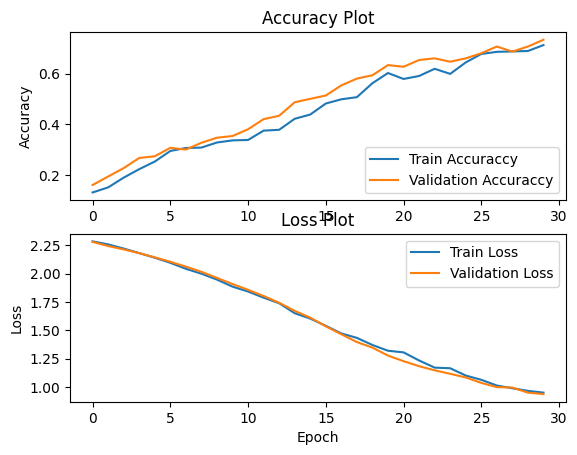

In [68]:
## plot loss and accuracy for training and validation
from matplotlib import pyplot as plt
def plot_history(history):
  fig, axs = plt.subplots(2)

  ##create accuracy sub-plot
  axs[0].plot(history.history["accuracy"], label="Train Accuraccy")
  axs[0].plot(history.history["val_accuracy"], label="Validation Accuraccy")
  axs[0].set_ylabel("Accuracy")
  # axs[0].set_xlabel("Epoch")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy Plot")

  ##create loss sub-plot
  axs[1].plot(history.history["loss"], label="Train Loss")
  axs[1].plot(history.history["val_loss"], label="Validation Loss")
  axs[1].set_ylabel("Loss")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Loss Plot")

  plt.show()

plot_history(history)

## from curve we can see model is under fit - model have not be trained to optimal limit - can be further trained- have not converged yet

In [72]:
## make prediction on sample

def predict(model, X, y):
  print(X.shape)
  X = X[np.newaxis, ...]
  print(X.shape)


  predictions =  model.predict(X)
  predict_index = np.argmax(predictions, axis=1)    ## get the index with highest value from index 1
  print("Expected index :{} \nPredicted index: {}".format(y, predict_index))
  return predict_index

## list of music gerne
maps = [
        "blues",
        "classical",
        "country",
        "disco",
        "hiphop",
        "jazz",
        "metal",
        "pop",
        "reggae",
        "rock"
    ]

X = X_test[100]
y = y_test[100]

## we have 250 test-set

per_i = predict(model, X, y)
print("\n\nExpected Genre : {} \nPredicted Genre: {}".format(maps[y], maps[per_i[0]]))


(130, 13)
(1, 130, 13)
1/1 [==============================] - 0s 31ms/step
Expected index :6 
Predicted index: [6]


Expected Genre : metal 
Predicted Genre: metal


In [74]:
X = X_test[200]
y = y_test[200]
per_i = predict(model, X, y)
print("\n\nExpected Genre : {} \nPredicted Genre: {}".format(maps[y], maps[per_i[0]]))


(130, 13)
(1, 130, 13)
1/1 [==============================] - 0s 88ms/step
Expected index :1 
Predicted index: [1]


Expected Genre : classical 
Predicted Genre: classical


In [78]:
X = X_test[69]
y = y_test[69]
per_i = predict(model, X, y)
print("\n\nExpected Genre : {} \nPredicted Genre: {}".format(maps[y], maps[per_i[0]]))


(130, 13)
(1, 130, 13)
1/1 [==============================] - 0s 35ms/step
Expected index :5 
Predicted index: [0]


Expected Genre : jazz 
Predicted Genre: blues
